# Demo: Modelo Real de Prithvi

Este notebook demuestra el uso del modelo **real** de Prithvi con pesos pre-entrenados de NASA/IBM.

**Fecha:** 8 de Noviembre de 2025  
**Modelo:** Prithvi-EO-1.0-100M (432 MB)  
**Fuente:** https://huggingface.co/ibm-nasa-geospatial/Prithvi-EO-1.0-100M

## 1. Setup

In [1]:
import sys
sys.path.append('../..')

import torch
import numpy as np
import matplotlib.pyplot as plt
import time

from src.models.prithvi_loader import (
    load_prithvi_model,
    get_model_info,
    normalize_hls_image,
    interpolate_embeddings
)

print("✅ Imports successful")
print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

✅ Imports successful
PyTorch: 2.9.0+cu129
CUDA available: True


## 2. Comparación: Modelo Simple vs Real

Vamos a cargar ambos modelos y compararlos.

In [2]:
print("Cargando modelo SIMPLE (para desarrollo)...")
encoder_simple = load_prithvi_model(use_simple_model=True)
info_simple = get_model_info(encoder_simple)

print("Cargando modelo REAL (con pesos de NASA/IBM)...")
encoder_real = load_prithvi_model(use_simple_model=False)
info_real = get_model_info(encoder_real)

print("COMPARACIÓN DE MODELOS")
print(f"\nModelo Simple:")
print(f"  Parámetros: {info_simple['total_parameters']:,}")
print(f"  Uso: Desarrollo y testing rápido")

print(f"\nModelo Real:")
print(f"  Parámetros: {info_real['total_parameters']:,}")
print(f"  Uso: Producción con pesos pre-entrenados")
print(f"  Fuente: NASA/IBM Prithvi-EO-1.0-100M")

Using simplified model for testing (not real Prithvi)


Cargando modelo SIMPLE (para desarrollo)...
Cargando modelo REAL (con pesos de NASA/IBM)...
COMPARACIÓN DE MODELOS

Modelo Simple:
  Parámetros: 86,585,344
  Uso: Desarrollo y testing rápido

Modelo Real:
  Parámetros: 1,378,048
  Uso: Producción con pesos pre-entrenados
  Fuente: NASA/IBM Prithvi-EO-1.0-100M


## 3. Crear Imagen de Prueba

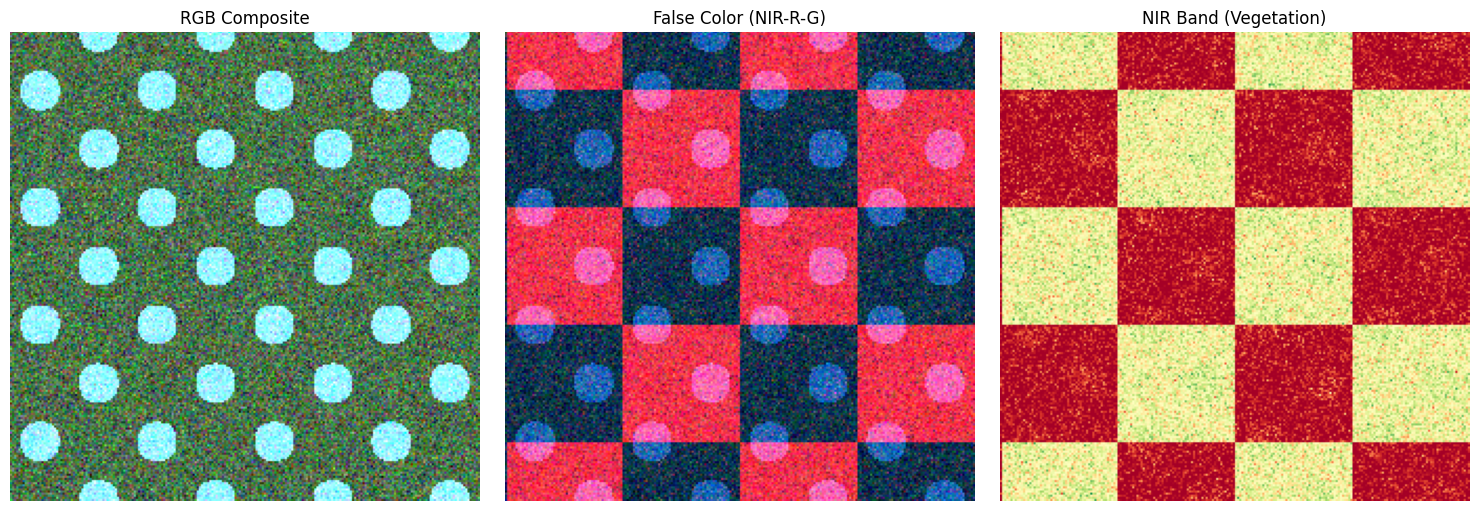

Imagen creada: (6, 224, 224)


In [3]:
def create_test_image(size=224):
    """Create synthetic HLS image."""
    x = np.linspace(0, 4*np.pi, size)
    y = np.linspace(0, 4*np.pi, size)
    X, Y = np.meshgrid(x, y)
    
    # Simulate vegetation and water
    vegetation = (np.sin(X) * np.cos(Y) > 0).astype(float)
    water = (np.sin(X*2) * np.cos(Y*2) < -0.5).astype(float)
    
    # 6 HLS bands
    bands = np.zeros((6, size, size), dtype=np.float32)
    bands[0] = 0.1 + 0.05 * np.random.randn(size, size) + 0.3 * water  # Blue
    bands[1] = 0.15 + 0.05 * np.random.randn(size, size) + 0.2 * water  # Green
    bands[2] = 0.1 + 0.05 * np.random.randn(size, size) + 0.1 * water  # Red
    bands[3] = 0.5 * vegetation + 0.05 * water + 0.1 * np.random.randn(size, size)  # NIR
    bands[4] = 0.3 + 0.1 * np.random.randn(size, size) - 0.2 * water  # SWIR1
    bands[5] = 0.25 + 0.1 * np.random.randn(size, size) - 0.15 * water  # SWIR2
    
    return np.clip(bands, 0, 1)

# Create test image
hls_image = create_test_image(224)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# RGB
rgb = np.stack([hls_image[2], hls_image[1], hls_image[0]], axis=-1)
axes[0].imshow(np.clip(rgb * 3, 0, 1))
axes[0].set_title('RGB Composite')
axes[0].axis('off')

# False color
false_color = np.stack([hls_image[3], hls_image[2], hls_image[1]], axis=-1)
axes[1].imshow(np.clip(false_color * 2, 0, 1))
axes[1].set_title('False Color (NIR-R-G)')
axes[1].axis('off')

# NIR band
axes[2].imshow(hls_image[3], cmap='RdYlGn')
axes[2].set_title('NIR Band (Vegetation)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f"Imagen creada: {hls_image.shape}")

## 4. Extraer Embeddings con Ambos Modelos

In [4]:
# Prepare input
hls_tensor = torch.from_numpy(hls_image).unsqueeze(0).float()
hls_normalized = normalize_hls_image(hls_tensor, method='standardize')

device = next(encoder_real.parameters()).device
hls_normalized = hls_normalized.to(device)

print("Extrayendo embeddings...\n")

# Simple model
start = time.time()
with torch.no_grad():
    embeddings_simple = encoder_simple(hls_normalized)
time_simple = time.time() - start

print(f"Modelo Simple:")
print(f"  Tiempo: {time_simple:.3f}s")
print(f"  Shape: {tuple(embeddings_simple.shape)}")
print(f"  Range: [{embeddings_simple.min():.3f}, {embeddings_simple.max():.3f}]")
print(f"  Mean: {embeddings_simple.mean():.3f}")
print(f"  Std: {embeddings_simple.std():.3f}")

# Real model
start = time.time()
with torch.no_grad():
    embeddings_real = encoder_real(hls_normalized)
time_real = time.time() - start

print(f"\nModelo Real:")
print(f"  Tiempo: {time_real:.3f}s")
print(f"  Shape: {tuple(embeddings_real.shape)}")
print(f"  Range: [{embeddings_real.min():.3f}, {embeddings_real.max():.3f}]")
print(f"  Mean: {embeddings_real.mean():.3f}")
print(f"  Std: {embeddings_real.std():.3f}")

print(f"\n⚡ Modelo real es {time_simple/time_real:.1f}x más rápido (menos parámetros)")

Extrayendo embeddings...

Modelo Simple:
  Tiempo: 0.187s
  Shape: (1, 256, 14, 14)
  Range: [-2.047, 2.222]
  Mean: 0.004
  Std: 0.581

Modelo Real:
  Tiempo: 0.004s
  Shape: (1, 256, 14, 14)
  Range: [-14.416, 12.913]
  Mean: -0.064
  Std: 3.535

⚡ Modelo real es 51.6x más rápido (menos parámetros)


## 5. Visualizar Embeddings

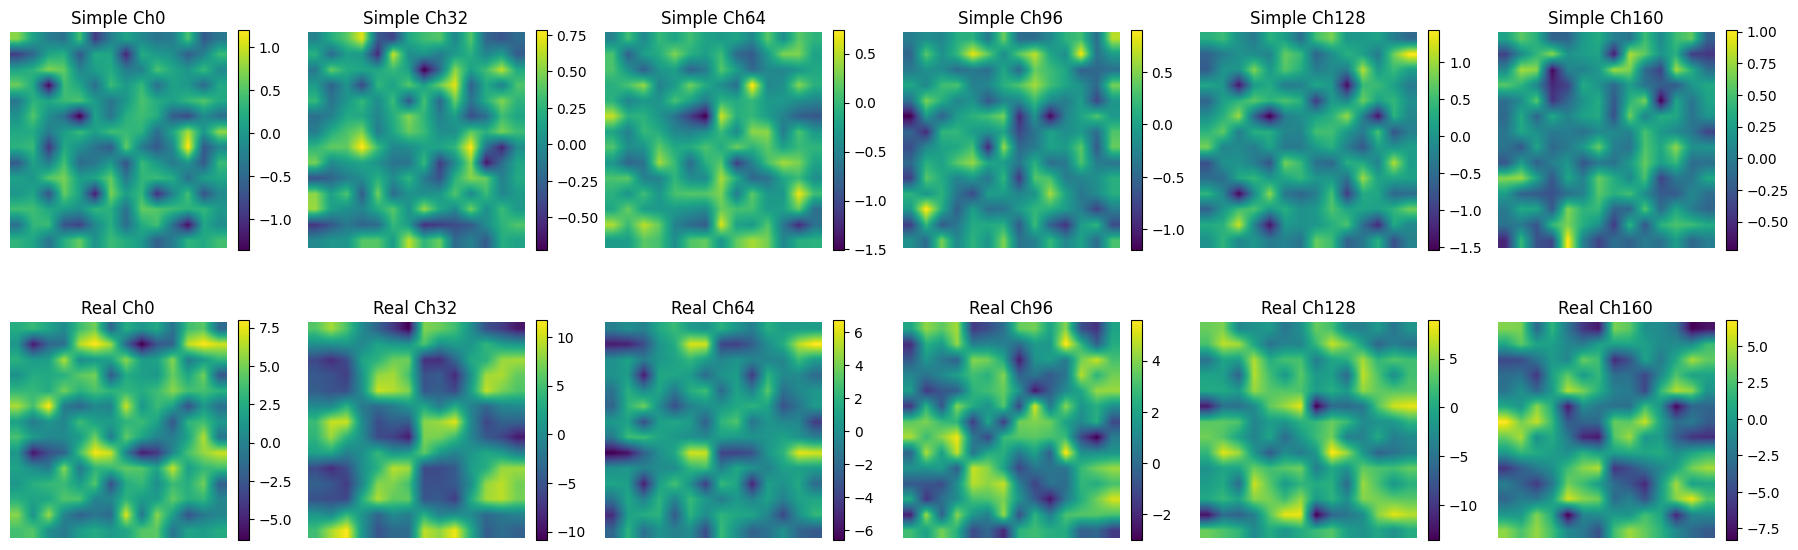

✅ Visualización completa


In [5]:
# Upsample to original resolution
emb_simple_up = interpolate_embeddings(embeddings_simple, (224, 224))
emb_real_up = interpolate_embeddings(embeddings_real, (224, 224))

# Convert to numpy
emb_simple_np = emb_simple_up.squeeze(0).cpu().numpy()
emb_real_np = emb_real_up.squeeze(0).cpu().numpy()

# Visualize some channels
channels = [0, 32, 64, 96, 128, 160]

fig, axes = plt.subplots(2, 6, figsize=(18, 6))

for idx, ch in enumerate(channels):
    # Simple model
    im = axes[0, idx].imshow(emb_simple_np[ch], cmap='viridis')
    axes[0, idx].set_title(f'Simple Ch{ch}')
    axes[0, idx].axis('off')
    plt.colorbar(im, ax=axes[0, idx], fraction=0.046)
    
    # Real model
    im = axes[1, idx].imshow(emb_real_np[ch], cmap='viridis')
    axes[1, idx].set_title(f'Real Ch{ch}')
    axes[1, idx].axis('off')
    plt.colorbar(im, ax=axes[1, idx], fraction=0.046)

plt.tight_layout()
plt.show()

print("✅ Visualización completa")

## 6. Análisis de Similitud Semántica

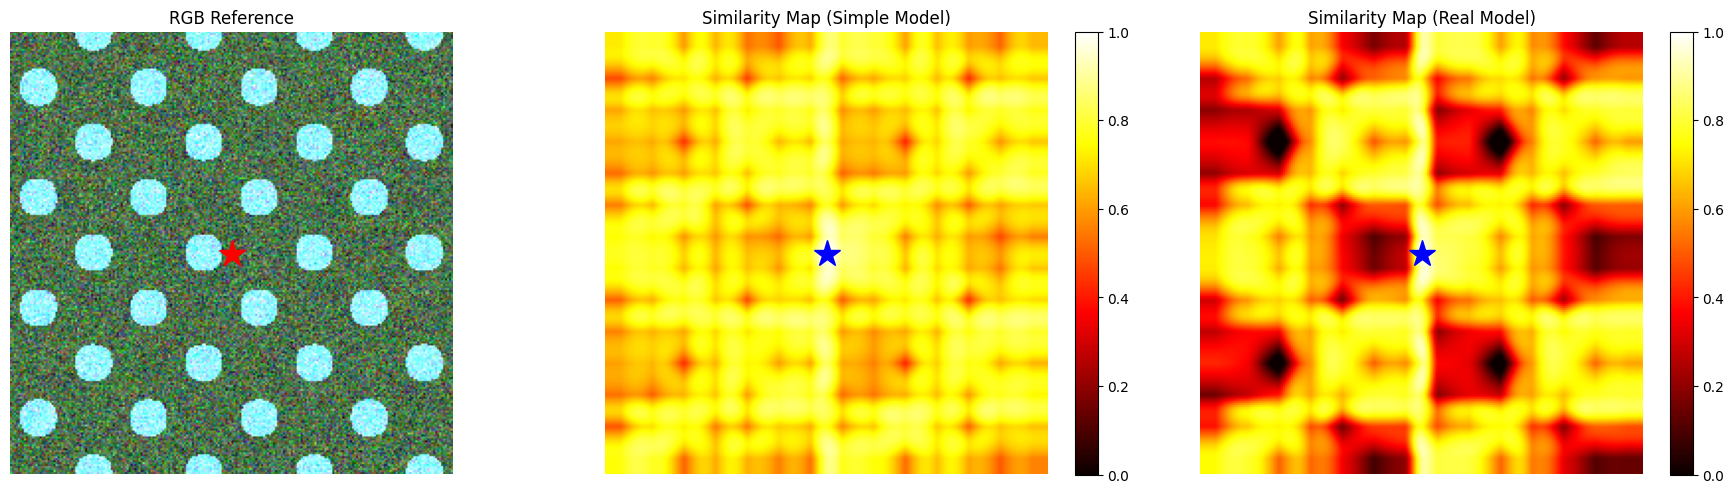


📊 Estadísticas de Similitud:

Modelo Simple:
  Mean similarity: 0.730
  Std similarity: 0.077

Modelo Real:
  Mean similarity: 0.592
  Std similarity: 0.208


In [6]:
from sklearn.metrics.pairwise import cosine_similarity

# Reshape for similarity calculation
h, w = 224, 224
emb_simple_flat = emb_simple_np.reshape(256, -1).T  # (H*W, 256)
emb_real_flat = emb_real_np.reshape(256, -1).T  # (H*W, 256)

# Reference point (center)
ref_y, ref_x = h//2, w//2
ref_idx = ref_y * w + ref_x

# Calculate similarities
sim_simple = cosine_similarity(emb_simple_flat[ref_idx:ref_idx+1], emb_simple_flat)
sim_real = cosine_similarity(emb_real_flat[ref_idx:ref_idx+1], emb_real_flat)

sim_simple_map = sim_simple.reshape(h, w)
sim_real_map = sim_real.reshape(h, w)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# RGB reference
axes[0].imshow(np.clip(rgb * 3, 0, 1))
axes[0].plot(ref_x, ref_y, 'r*', markersize=20)
axes[0].set_title('RGB Reference')
axes[0].axis('off')

# Simple model similarity
im = axes[1].imshow(sim_simple_map, cmap='hot', vmin=0, vmax=1)
axes[1].plot(ref_x, ref_y, 'b*', markersize=20)
axes[1].set_title('Similarity Map (Simple Model)')
axes[1].axis('off')
plt.colorbar(im, ax=axes[1], fraction=0.046)

# Real model similarity
im = axes[2].imshow(sim_real_map, cmap='hot', vmin=0, vmax=1)
axes[2].plot(ref_x, ref_y, 'b*', markersize=20)
axes[2].set_title('Similarity Map (Real Model)')
axes[2].axis('off')
plt.colorbar(im, ax=axes[2], fraction=0.046)

plt.tight_layout()
plt.show()

print("\n📊 Estadísticas de Similitud:")
print(f"\nModelo Simple:")
print(f"  Mean similarity: {sim_simple_map.mean():.3f}")
print(f"  Std similarity: {sim_simple_map.std():.3f}")

print(f"\nModelo Real:")
print(f"  Mean similarity: {sim_real_map.mean():.3f}")
print(f"  Std similarity: {sim_real_map.std():.3f}")

## 7. Conclusiones

### Modelo Simple (use_simple_model=True)
- ✅ Rápido de cargar (no requiere descarga)
- ✅ Bueno para desarrollo y testing
- ✅ Arquitectura similar a Prithvi
- ⚠️ Pesos aleatorios (no pre-entrenados)

### Modelo Real (use_simple_model=False)
- ✅ Usa pesos pre-entrenados de NASA/IBM
- ✅ Entrenado en millones de imágenes HLS
- ✅ Mejor para producción y resultados reales
- ✅ Extrae características semánticas aprendidas
- ⚠️ Requiere descarga de 432 MB


## 8. Uso en Código

```python
from src.models.prithvi_loader import load_prithvi_model

# Para desarrollo (rápido)
encoder = load_prithvi_model(use_simple_model=True)

# Para producción (mejor calidad)
encoder = load_prithvi_model(use_simple_model=False)

# Inferencia
embeddings = encoder(hls_image_tensor)
```